# Inference Notebook

[MAXIM: Multi-Axis MLP for Image Processing (CVPR 2022 Oral)](https://github.com/google-research/maxim)

**This is just the inference code. Maximum you can do is to come in with your images and get results using trained models**

# Clone repo and install dependencies

In [1]:
! git clone https://github.com/google-research/maxim/
%cd ./maxim

!pip install -r requirements.txt


!python setup.py build
! python setup.py install

# https://console.cloud.google.com/storage/browser/gresearch/maxim/ckpt/Enhancement/FiveK;tab=objects?prefix=&forceOnObjectsSortingFiltering=false

Cloning into 'maxim'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 81 (delta 22), reused 64 (delta 10), pack-reused 0
Unpacking objects: 100% (81/81), done.
/content/maxim
     |████████████████████████████████| 72 kB 546 kB/s 
     |████████████████████████████████| 77 kB 6.3 MB/s 
     |████████████████████████████████| 184 kB 41.7 MB/s 
     |████████████████████████████████| 88 kB 8.0 MB/s 
     |████████████████████████████████| 140 kB 38.6 MB/s 
     |████████████████████████████████| 462 kB 46.6 MB/s 
running build
running build_py
creating build
creating build/lib
creating build/lib/maxim
copying maxim/__init__.py -> build/lib/maxim
copying maxim/test_maxim.py -> build/lib/maxim
copying maxim/run_eval.py -> build/lib/maxim
creating build/lib/maxim/models
copying maxim/models/__init__.py -> build/lib/maxim/models
copying maxim/models/maxim.py -> build/lib/maxim/models
running

# Imports and Defaults
Imports from libraries and from the modules written by authors of the repo



In [2]:
from google.colab import drive # works only for colab
from PIL import Image

import matplotlib.pyplot as plt
import collections
import importlib
import io
import os

import flax
import jax.numpy as jnp
import ml_collections
import numpy as np
import tensorflow as tf

# below code lines are from run_eval.py
_MODEL_FILENAME = 'maxim'

_MODEL_VARIANT_DICT = {
    'Denoising': 'S-3',
    'Deblurring': 'S-3',
    'Deraining': 'S-2',
    'Dehazing': 'S-2',
    'Enhancement': 'S-2',
}

_MODEL_CONFIGS = {
    'variant': '',
    'dropout_rate': 0.0,
    'num_outputs': 3,
    'use_bias': True,
    'num_supervision_scales': 3,
}


# Link Google Drive for data input and output 
Not necessary but ease of use for Data input / Output

In [3]:
drive.mount('/content/gdrive/',)

Mounted at /content/gdrive/


# Helpers

In [4]:

def resize(path, new_width_height = 1280, save_image = False, convert_RGB = True, clip_full_hd = False, quality = 100):
  '''
  Resize and return Given Image
  args:
    path: Image Path
    new_width_height = Reshaped image's width and height. # If integer is given, it'll keep the aspect ratio as it is by shrinking the Bigger dimension (width or height) to the max of new_width_height  and then shring the smaller dimension accordingly 
    save_image = Whether to save the image or not
    convert_RGB: Whether to Convert the RGBA image to RGB (by default backgroud is white)
  '''
  image = Image.open(path)
  w, h = image.size

  fixed_size = new_width_height if isinstance(new_width_height, int) else False

  if fixed_size:
    if h > w:
      fixed_height = fixed_size
      height_percent = (fixed_height / float(h))
      width_size = int((float(w) * float(height_percent)))
      image = image.resize((width_size, fixed_height), Image.NEAREST)

    else:
      fixed_width = fixed_size
      width_percent = (fixed_width / float(w))
      height_size = int((float(h) * float(width_percent)))
      image = image.resize((fixed_width, height_size), Image.NEAREST) # Try Image.ANTIALIAS inplace of Image.NEAREST

  else:
    image = image.resize(new_width_height)

  if image.mode == "RGBA" and convert_RGB:
    # image.load() # required for png.split()
    # new = Image.new("RGB", image.size, (255, 255, 255)) # White Background
    # image = new.paste(image, mask=image.split()[3]) # 3 is the alpha channel

    new = Image.new("RGBA", image.size, "WHITE") # Create a white rgba background
    new.paste(image, (0, 0), image) # Paste the image on the background.
    image = new.convert('RGB')

  if save_image:
    image.save(path, quality = quality)

  return image


class DummyFlags():
  def __init__(self, ckpt_path:str, task:str, input_dir: str = "./maxim/images/Enhancement", output_dir:str = "./maxim/images/Results", has_target:bool = False, save_images:bool = True, geometric_ensemble:bool = False):
    '''
    Builds the dummy flags which replicates the behaviour of Terminal CLI execution (same as ArgParse)
    args:
      ckpt_path: Saved Model CheckPoint: Find all the checkpoints for pre trained models at https://console.cloud.google.com/storage/browser/gresearch/maxim/ckpt/
      task: Task for which the model waas trained. Each task uses different Data and Checkpoints. Find the details of tasks and respective checkpoints details at: https://github.com/google-research/maxim#results-and-pre-trained-models
      input_dir: Input Directory. We do not need it here as we are directly passing one image at a time
      output_dir: Also not needed in out code
      has_target: Used to calculate PSNR and SSIM calculation. Not needed in our case
      save_images: Used in CLI command where images were saved in loop. Not needed in our case
      geometric_ensemble: Was used in training part and as it is just an Inference part, it is not needed

    '''
    self.ckpt_path = ckpt_path
    self.task = task
    self.input_dir = input_dir
    self.output_dir = output_dir
    self.has_target = has_target
    self.save_images = save_images
    self.geometric_ensemble = geometric_ensemble


# Refactored code from authors (`run_eval.py`)

**NOTE**: This is not my code. I just changed the structure, redirected dependencies within modules, removed redundant imports and code and bla bla bla....

In [5]:
# Copyright 2022 Google LLC.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


def recover_tree(keys, values):
  """Recovers a tree as a nested dict from flat names and values.

  This function is useful to analyze checkpoints that are saved by our programs
  without need to access the exact source code of the experiment. In particular,
  it can be used to extract an reuse various subtrees of the scheckpoint, e.g.
  subtree of parameters.
  Args:
    keys: a list of keys, where '/' is used as separator between nodes.
    values: a list of leaf values.
  Returns:
    A nested tree-like dict.
  """
  tree = {}
  sub_trees = collections.defaultdict(list)
  for k, v in zip(keys, values):
    if '/' not in k:
      tree[k] = v
    else:
      k_left, k_right = k.split('/', 1)
      sub_trees[k_left].append((k_right, v))
  for k, kv_pairs in sub_trees.items():
    k_subtree, v_subtree = zip(*kv_pairs)
    tree[k] = recover_tree(k_subtree, v_subtree)
  return tree


def mod_padding_symmetric(image, factor=64):
  """Padding the image to be divided by factor."""
  height, width = image.shape[0], image.shape[1]
  height_pad, width_pad = ((height + factor) // factor) * factor, (
      (width + factor) // factor) * factor
  padh = height_pad - height if height % factor != 0 else 0
  padw = width_pad - width if width % factor != 0 else 0
  image = jnp.pad(
      image, [(padh // 2, padh // 2), (padw // 2, padw // 2), (0, 0)],
      mode='reflect')
  return image


def get_params(ckpt_path):
  """Get params checkpoint."""

  with tf.io.gfile.GFile(ckpt_path, 'rb') as f:
    data = f.read()
  values = np.load(io.BytesIO(data))
  params = recover_tree(*zip(*values.items()))
  params = params['opt']['target']

  return params


def calculate_psnr(img1, img2, crop_border, test_y_channel=False):
  """Calculate PSNR (Peak Signal-to-Noise Ratio).

  Ref: https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
  Args:
    img1 (ndarray): Images with range [0, 255].
    img2 (ndarray): Images with range [0, 255].
    crop_border (int): Cropped pixels in each edge of an image. These
        pixels are not involved in the PSNR calculation.
    test_y_channel (bool): Test on Y channel of YCbCr. Default: False.
  Returns:
    float: psnr result.
  """
  assert img1.shape == img2.shape, (
      f'Image shapes are differnet: {img1.shape}, {img2.shape}.')
  img1 = img1.astype(np.float64)
  img2 = img2.astype(np.float64)

  if crop_border != 0:
    img1 = img1[crop_border:-crop_border, crop_border:-crop_border, ...]
    img2 = img2[crop_border:-crop_border, crop_border:-crop_border, ...]

  if test_y_channel:
    img1 = to_y_channel(img1)
    img2 = to_y_channel(img2)

  mse = np.mean((img1 - img2)**2)
  if mse == 0:
    return float('inf')
  return 20. * np.log10(255. / np.sqrt(mse))


def _convert_input_type_range(img):
  """Convert the type and range of the input image.

  It converts the input image to np.float32 type and range of [0, 1].
  It is mainly used for pre-processing the input image in colorspace
  convertion functions such as rgb2ycbcr and ycbcr2rgb.
  Args:
    img (ndarray): The input image. It accepts:
        1. np.uint8 type with range [0, 255];
        2. np.float32 type with range [0, 1].
  Returns:
      (ndarray): The converted image with type of np.float32 and range of
          [0, 1].
  """
  img_type = img.dtype
  img = img.astype(np.float32)
  if img_type == np.float32:
    pass
  elif img_type == np.uint8:
    img /= 255.
  else:
    raise TypeError('The img type should be np.float32 or np.uint8, '
                    f'but got {img_type}')
  return img


def _convert_output_type_range(img, dst_type):
  """Convert the type and range of the image according to dst_type.

  It converts the image to desired type and range. If `dst_type` is np.uint8,
  images will be converted to np.uint8 type with range [0, 255]. If
  `dst_type` is np.float32, it converts the image to np.float32 type with
  range [0, 1].
  It is mainly used for post-processing images in colorspace convertion
  functions such as rgb2ycbcr and ycbcr2rgb.
  Args:
    img (ndarray): The image to be converted with np.float32 type and
        range [0, 255].
    dst_type (np.uint8 | np.float32): If dst_type is np.uint8, it
        converts the image to np.uint8 type with range [0, 255]. If
        dst_type is np.float32, it converts the image to np.float32 type
        with range [0, 1].
  Returns:
    (ndarray): The converted image with desired type and range.
  """
  if dst_type not in (np.uint8, np.float32):
    raise TypeError('The dst_type should be np.float32 or np.uint8, '
                    f'but got {dst_type}')
  if dst_type == np.uint8:
    img = img.round()
  else:
    img /= 255.

  return img.astype(dst_type)


def rgb2ycbcr(img, y_only=False):
  """Convert a RGB image to YCbCr image.

  This function produces the same results as Matlab's `rgb2ycbcr` function.
  It implements the ITU-R BT.601 conversion for standard-definition
  television. See more details in
  https://en.wikipedia.org/wiki/YCbCr#ITU-R_BT.601_conversion.
  It differs from a similar function in cv2.cvtColor: `RGB <-> YCrCb`.
  In OpenCV, it implements a JPEG conversion. See more details in
  https://en.wikipedia.org/wiki/YCbCr#JPEG_conversion.

  Args:
    img (ndarray): The input image. It accepts:
        1. np.uint8 type with range [0, 255];
        2. np.float32 type with range [0, 1].
    y_only (bool): Whether to only return Y channel. Default: False.
  Returns:
    ndarray: The converted YCbCr image. The output image has the same type
        and range as input image.
  """
  img_type = img.dtype
  img = _convert_input_type_range(img)
  if y_only:
    out_img = np.dot(img, [65.481, 128.553, 24.966]) + 16.0
  else:
    out_img = np.matmul(img,
                        [[65.481, -37.797, 112.0], [128.553, -74.203, -93.786],
                         [24.966, 112.0, -18.214]]) + [16, 128, 128]
  out_img = _convert_output_type_range(out_img, img_type)
  return out_img


def to_y_channel(img):
  """Change to Y channel of YCbCr.

  Args:
    img (ndarray): Images with range [0, 255].
  Returns:
    (ndarray): Images with range [0, 255] (float type) without round.
  """
  img = img.astype(np.float32) / 255.
  if img.ndim == 3 and img.shape[2] == 3:
    img = rgb2ycbcr(img, y_only=True)
    img = img[..., None]
  return img * 255.


def augment_image(image, times=8):
  """Geometric augmentation."""
  if times == 4:  # only rotate image
    images = []
    for k in range(0, 4):
      images.append(np.rot90(image, k=k))
    images = np.stack(images, axis=0)
  elif times == 8:  # roate and flip image
    images = []
    for k in range(0, 4):
      images.append(np.rot90(image, k=k))
    image = np.fliplr(image)
    for k in range(0, 4):
      images.append(np.rot90(image, k=k))
    images = np.stack(images, axis=0)
  else:
    raise Exception(f'Error times: {times}')
  return images


def deaugment_image(images, times=8):
  """Reverse the geometric augmentation."""

  if times == 4:  # only rotate image
    image = []
    for k in range(0, 4):
      image.append(np.rot90(images[k], k=4-k))
    image = np.stack(image, axis=0)
    image = np.mean(image, axis=0)
  elif times == 8:  # roate and flip image
    image = []
    for k in range(0, 4):
      image.append(np.rot90(images[k], k=4-k))
    for k in range(0, 4):
      image.append(np.fliplr(np.rot90(images[4+k], k=4-k)))
    image = np.mean(image, axis=0)
  else:
    raise Exception(f'Error times: {times}')
  return image


def is_image_file(filename):
  """Check if it is an valid image file by extension."""
  return any(
      filename.endswith(extension)
      for extension in ['jpeg', 'JPEG', 'jpg', 'png', 'JPG', 'PNG', 'gif'])


def save_img(img, pth):
  """Save an image to disk.

  Args:
    img: jnp.ndarry, [height, width, channels], img will be clipped to [0, 1]
      before saved to pth.
    pth: string, path to save the image to.
  """
  Image.fromarray(np.array(
      (np.clip(img, 0., 1.) * 255.).astype(jnp.uint8))).save(pth, 'PNG')


def make_shape_even(image):
  """Pad the image to have even shapes."""
  height, width = image.shape[0], image.shape[1]
  padh = 1 if height % 2 != 0 else 0
  padw = 1 if width % 2 != 0 else 0
  image = jnp.pad(image, [(0, padh), (0, padw), (0, 0)], mode='reflect')
  return image


# Refactored code --------------------------------------------------------------------------------------------------------------------

def build_model(task = "Dehazing"):
  model_mod = importlib.import_module(f'maxim.models.{_MODEL_FILENAME}')
  model_configs = ml_collections.ConfigDict(_MODEL_CONFIGS)

  model_configs.variant = _MODEL_VARIANT_DICT[task]

  model = model_mod.Model(**model_configs)
  return model


def predict(input_file):
  input_img = np.asarray(Image.open(input_file).convert('RGB'),np.float32) / 255.

  # Padding images to have even shapes
  height, width = input_img.shape[0], input_img.shape[1]
  input_img = make_shape_even(input_img)
  height_even, width_even = input_img.shape[0], input_img.shape[1]

  # padding images to be multiplies of 64
  input_img = mod_padding_symmetric(input_img, factor=64)

  
  input_img = np.expand_dims(input_img, axis=0)

  # handle multi-stage outputs, obtain the last scale output of last stage
  preds = model.apply({'params': flax.core.freeze(params)}, input_img)
  if isinstance(preds, list):
    preds = preds[-1]
    if isinstance(preds, list):
      preds = preds[-1]

  # De-ensemble by averaging inferenced results.
  preds = np.array(preds[0], np.float32)

  # unpad images to get the original resolution
  new_height, new_width = preds.shape[0], preds.shape[1]
  h_start = new_height // 2 - height_even // 2
  h_end = h_start + height
  w_start = new_width // 2 - width_even // 2
  w_end = w_start + width
  preds = preds[h_start:h_end, w_start:w_end, :]
  return np.array((np.clip(preds, 0., 1.) * 255.).astype(jnp.uint8))

# Default Configs and Model Building
**Steps**:
1. Get the name of `task` and the respective `ckpt` (pre-trained saved model for that task) [Follow this link for task name and model](https://github.com/google-research/maxim#results-and-pre-trained-models)
2. Pass in the proper `task` and `ckpt_path` to the `DummyFlags`
3. Build Model

In [7]:
MODEL_PATH = "../gdrive/My Drive/maxim/adobe.npz" # pre-trained Model, trained on MIT Adobe 5K dataset for Enhancement, it is present in my Google drive with name "adobe.npz". You need to download from the link

FLAGS = DummyFlags(ckpt_path = MODEL_PATH, task = "Enhancement") # Path to your checkpoint and task name

params = get_params(FLAGS.ckpt_path) # Parse the config

model = build_model() # Build Model

# Inference
For Inference, you just need to pasd the *Image Path* to the the `predict` function. Result will be a `Numpy` array. You can easily save that by converting to `PIL` image.


**Note**: You might get `OOM` or Out of memory issue which is not a big deal if you image size is too big. In that case, you just need to use the `resize` function



In [ ]:
# image_path = "path/to/my/image.extension" # your image path
# enhanced_image_array = predict(image_path) # Get predictions

# enhanced_pil_image = Image.fromarray(enhanced_image_array) # get PIL image from array
# enhanced_pil_image.save("path/to/output/directory/image.extension") # Save the image


# Test Images from Drive and Save

**Note**: For huge number of images (say 50 or more), copy all the images from Google Drive to the current machine's drive else it will make the process so slow. And also for saving the enhanced image to drive, Get predictions for all the images at once, Save them here first and them copy a zip file to the drive.

In [ ]:
# images = ["../gdrive/My Drive/maxim/input/"+i for i in os.listdir("../gdrive/My Drive/maxim/input/") if i.endswith(('jpeg', 'png', 'jpg',"PNG","JPEG","JPG"))]

# # _ = [resize(path, 1920, save_image=True) for path in images] # Resize Images to 1920 as the max dimension's size else it'll blow the GPU / CPU memory


# for path in images:
#   im = Image.fromarray(predict(path))
#   im.save("../gdrive/My Drive/maxim/output/"+path.split('/')[-1])



# Visualization

The below code demonstrates how to predict from Image URL. You can directly use `predict(image_path)`

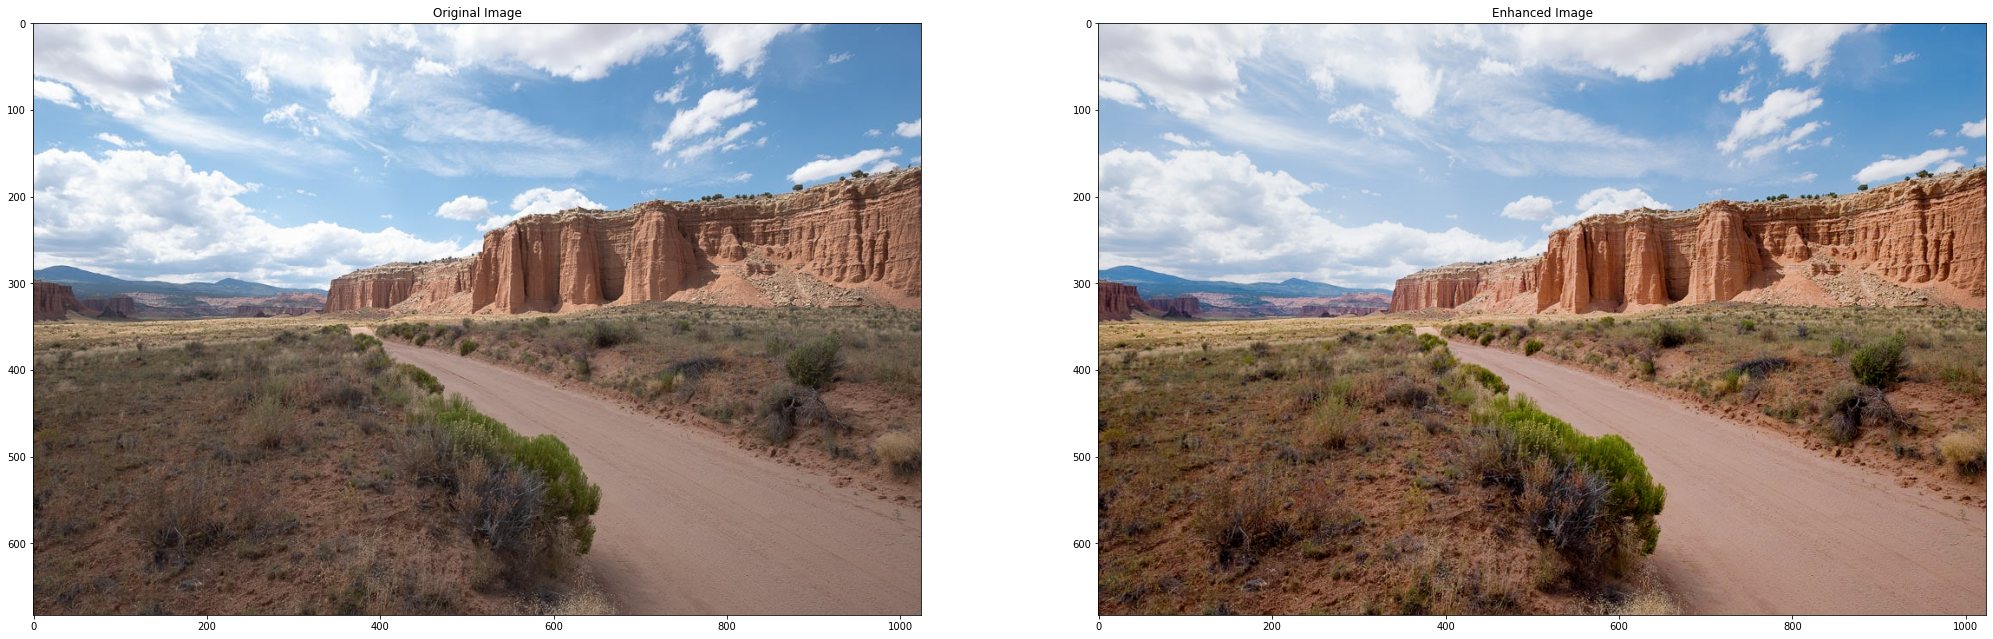

In [16]:
import requests
from io import BytesIO

url = "https://phototraces.b-cdn.net/wp-content/uploads/2021/02/id_Free_RAW_Photos_for_Editing_09_Uneditedd.jpg"
# url = "https://phototraces.b-cdn.net/wp-content/uploads/2021/03/Free_RAW_Photos_for_Editing_13_Unedited.jpg"

image_bytes = BytesIO(requests.get(url).content)

result = predict(image_bytes)

f, ax = plt.subplots(1,2, figsize = (35,20))

ax[0].imshow(np.array(Image.open(image_bytes))) # Original image
ax[1].imshow(result) # retouched image

ax[0].set_title("Original Image")
ax[1].set_title("Enhanced Image")

plt.show()